In [58]:
%reload_ext autoreload
%autoreload 2

from typing import Callable, Dict

import os
import datetime as dt
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config Inlinebackend.figure_format = 'retina'

In [59]:
# Plotting constants

In [60]:
# Constants

# Filepath
FILE_PATH = "/Users/lukasmalms/Desktop/DataScience/GitHub/german-power-grid/data/de-50hertz-demand-data.csv"

# Timezone
UTC = pytz.utc

# Month to int
MONTHS_OF_THE_YEAR = dict(zip(
    ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"],
    [i for i in range(1, 13)]
))

# Leap years
LEAP_YEARS = [2004, 2008, 2012, 2016, 2020]

# Days per month
def get_days_per_month() -> Callable[[int], Dict[str, int]]:
    
    def days_per_month(year: int) -> Dict[str, int]:
        return dict(zip(
            ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"],
            [31, (29 if year in LEAP_YEARS else 28), 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        ))

    return days_per_month

DAYS_PER_MONTH = get_days_per_month()

In [61]:
# Import data
df = pd.read_csv(
    filepath_or_buffer=FILE_PATH, 
    index_col="timestamp",
    parse_dates=True
).astype(
    {"quantity": float}
).rename(columns=
    {"quantity": "local_demand"}
)

# Set frequency
df.index.freq = df.index.inferred_freq

# View head
df.head()

,local_demand
timestamp,
2014-12-31 23:00:00+00:00,9275.0
2014-12-31 23:15:00+00:00,9240.0
2014-12-31 23:30:00+00:00,9204.0
2014-12-31 23:45:00+00:00,9127.0
2015-01-01 00:00:00+00:00,9080.0


## EDA

In [5]:
# Missing data?
print(df.reset_index().isna().any(axis=0))

timestamp       False
local_demand    False
dtype: bool


In [6]:
# Duplicate data?
df.loc[df.index.duplicated()]

,local_demand
timestamp,


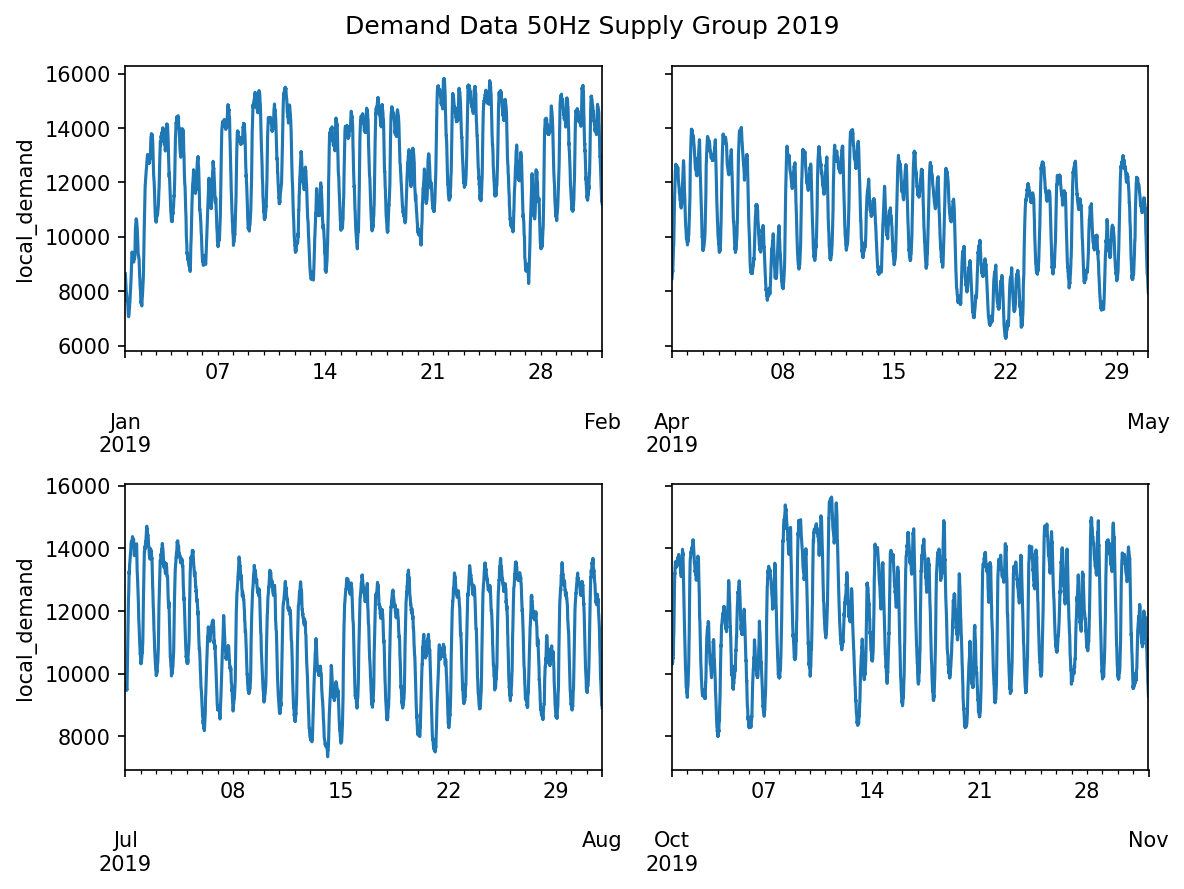

In [7]:
# Demand vs. time for 2019
fig, ax = plt.subplots(2, 2, dpi=150, figsize=(8, 6), sharey="row")

date_range = pd.date_range(
    start=UTC.localize(dt.datetime(2019, 1, 1)),
    end=UTC.localize(dt.datetime(2019, 12, 1)),
    freq="MS"
)

for i, (start, end) in enumerate(zip(date_range[::3], date_range[1::3])):
    
    # Slice df
    df_slice = df.loc[(df.index >= start) & (df.index <= end)]
    
    # Plot
    ax[i//2, i%2] = df_slice.plot(ax=ax[i//2, i%2], legend=False)
    ax[i//2, i%2].set_xlabel("")
    if i%2 == 0:
        ax[i//2, i%2].set_ylabel("local_demand")


fig.suptitle("Demand Data 50Hz Supply Group 2019")        
fig.tight_layout();

/Users/lukasmalms/Desktop/DataScience/venvs/german-power-grid/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


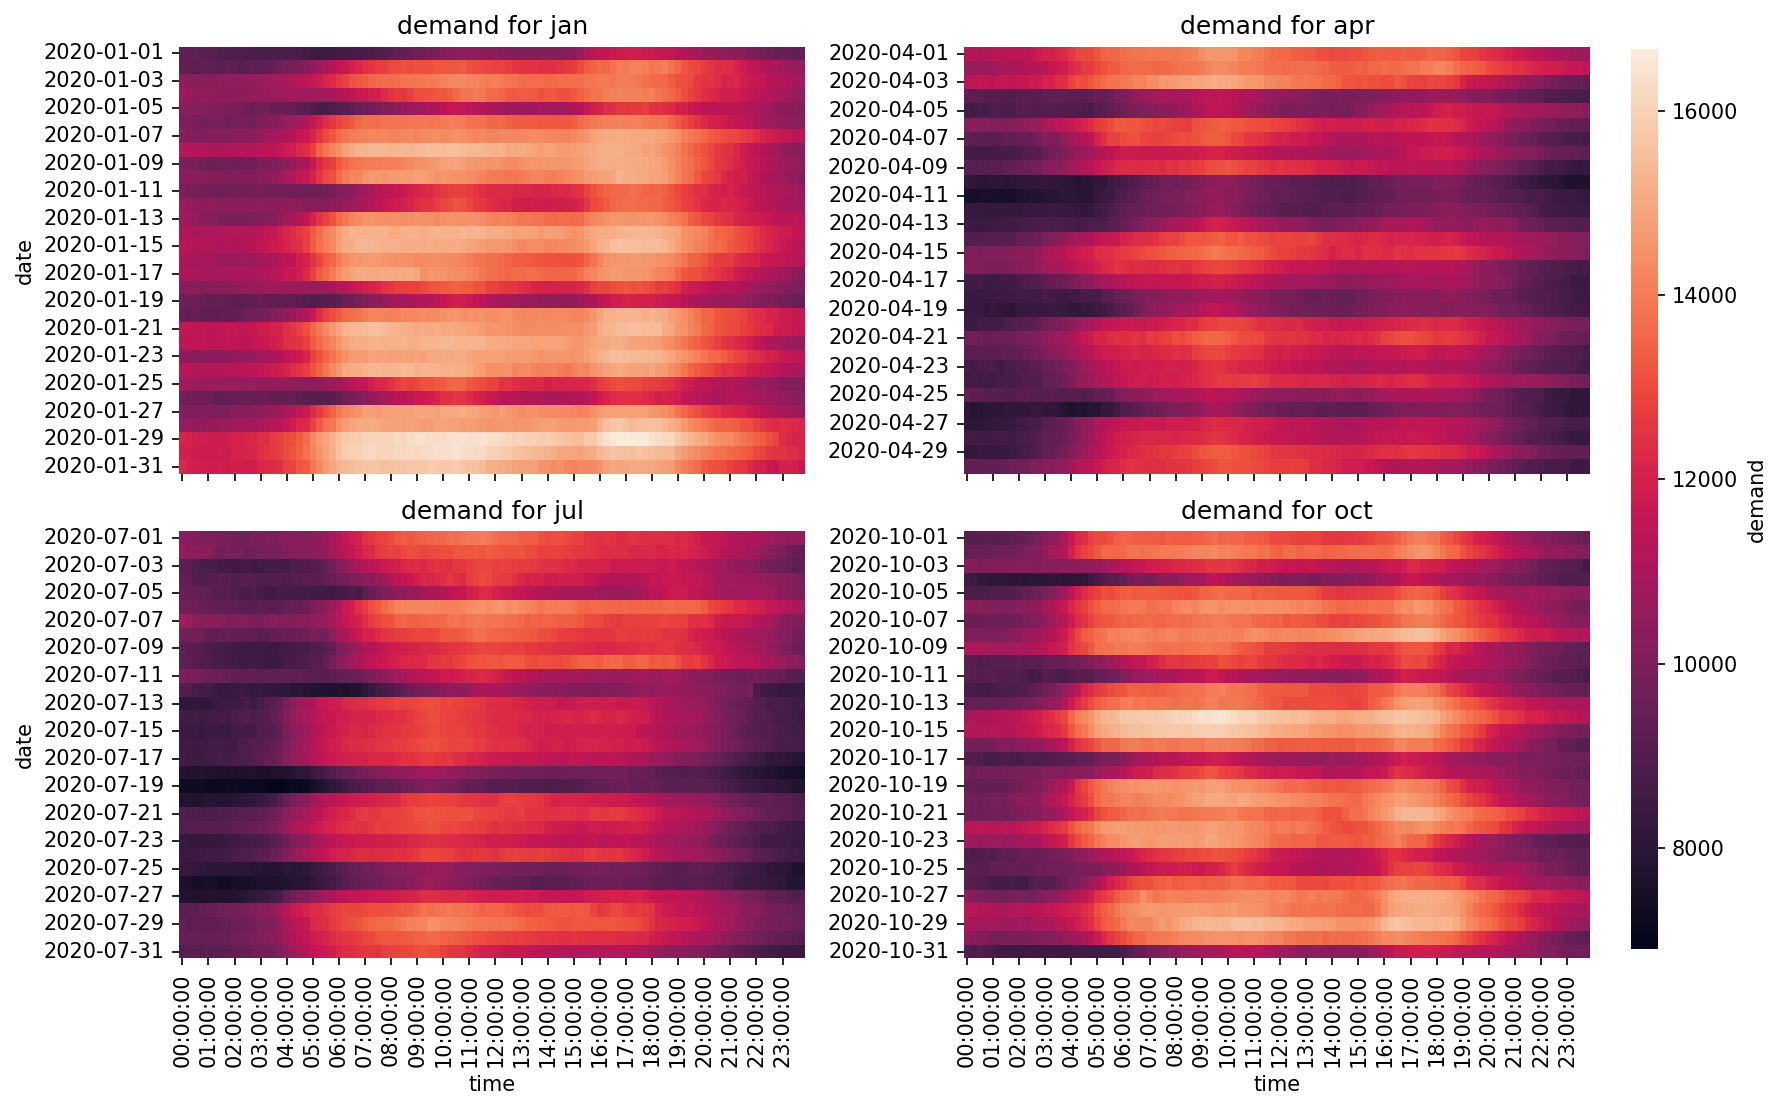

In [8]:
# Visualise demand data as heatmap
def plot_heat_map(year: int, month: str, **kwargs) -> plt.Axes:
    
    # Check month is valid
    assert month in MONTHS_OF_THE_YEAR
    
    # Define start and end dates
    days_in_month = DAYS_PER_MONTH(year)[month]
    month = MONTHS_OF_THE_YEAR[month]
    start = dt.datetime(year, month, 1, 0, 0, 0)
    end = dt.datetime(year, month, days_in_month, 23, 45, 0)
    
    # Slice df over month
    df_slice = df.loc[start: end]
    df_slice = df_slice.assign(date=df_slice.index.date, time=df_slice.index.time)
    
    # Create pivot table
    df_pivot = df_slice.pivot(index="date", columns="time", values="local_demand")

    # Plot heatmap
    return sns.heatmap(df_pivot, **kwargs)

year = 2020
months = ["jan", "apr", "jul", "oct"]

fig, ax = plt.subplots(2, 2, figsize=(12, 7.5), dpi=150, sharex=True)
cbar_ax = fig.add_axes([.91, 0.15, .015, .8])

# Get max and min values for selected months
min_values = []
max_values = []

for month in months:
    days_in_month = DAYS_PER_MONTH(year)[month]
    month = MONTHS_OF_THE_YEAR[month]
    start = dt.datetime(year, month, 1, 0, 0, 0)
    end = dt.datetime(year, month, days_in_month, 23, 45, 0)
    
    min_values.append(df.loc[start: end]["local_demand"].min())
    max_values.append(df.loc[start: end]["local_demand"].max())

for i, month in enumerate(months):
    plot_heat_map(
        year=year, 
        month=month, 
        ax=ax[i//2, i%2], 
        cbar=i==0,  # Only plot cbar for the first heatmap
        cbar_ax=None if i else cbar_ax,  # and plot it on this axis
        cbar_kws={"label": "demand"},
        vmin=np.min(min_values),
        vmax=np.max(max_values)
    )
    ax[i//2, i%2].set_title(f"demand for {month}")
    if i%2:
        ax[i//2, i%2].set_ylabel("")
    if not i//2:
        ax[i//2, i%2].set_xlabel("")
        
fig.tight_layout(rect=[0., 0., 0.9, 1])

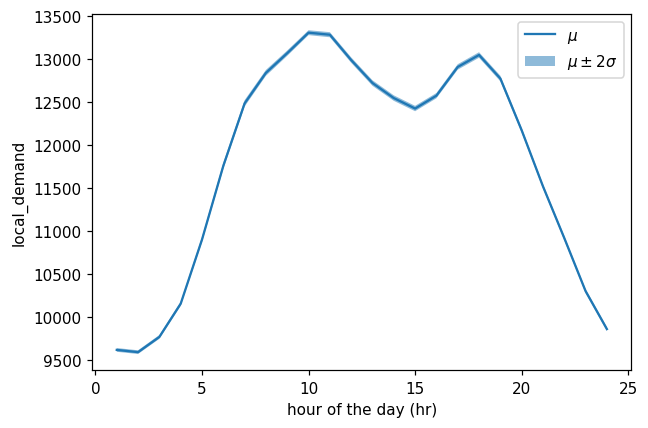

In [9]:
# Average consumption grouped by time of day
hourly_consumption_stats = df.groupby(df.index.hour).agg({
    "local_demand": ["mean", "sem"]
})

fig, ax = plt.subplots(1, 1, dpi=110)
mean = np.array(hourly_consumption_stats[("local_demand", "mean")])
err = np.array(hourly_consumption_stats[("local_demand", "sem")])
ax.plot(np.arange(1, 25), mean, label="$\mu$")
ax.fill_between(np.arange(1, 25), mean-2*err, mean+2*err, label="$\mu\pm2\sigma$", alpha=0.5, lw=0)

ax.legend()
ax.set_xlabel("hour of the day (hr)")
ax.set_ylabel("local_demand")
fig.tight_layout();

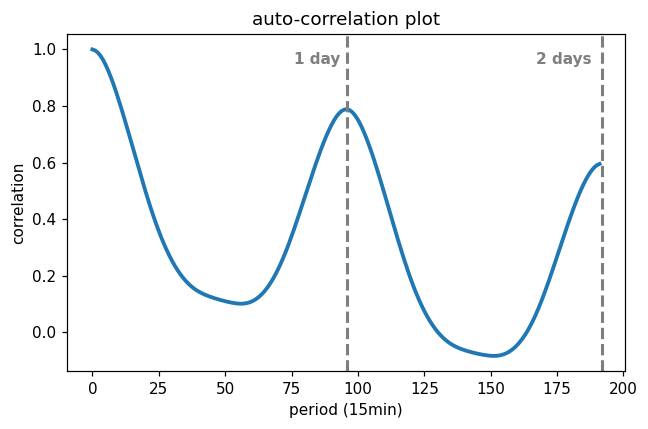

In [10]:
# Autocorrelation
fig, ax = plt.subplots(1, 1, dpi=110)
max_lags = 2 * 24 * 4  # 2 days 
ax.plot(
    np.arange(max_lags),
    np.array([df["local_demand"].autocorr(lag=lag) for lag in range(max_lags)]),
    lw=2.5
)

ax.axvline(1*24*4, color="tab:grey", lw=2, ls="--")
ax.axvline(2*24*4, color="tab:grey", lw=2, ls="--")
ax.annotate("1 day", (1*24*4-20, 0.95), color="tab:grey", weight="bold")
ax.annotate("2 days", (2*24*4-25, 0.95), color="tab:grey", weight="bold")
ax.set_xlabel("period (15min)")
ax.set_ylabel("correlation")
ax.set_title("auto-correlation plot")
fig.tight_layout();

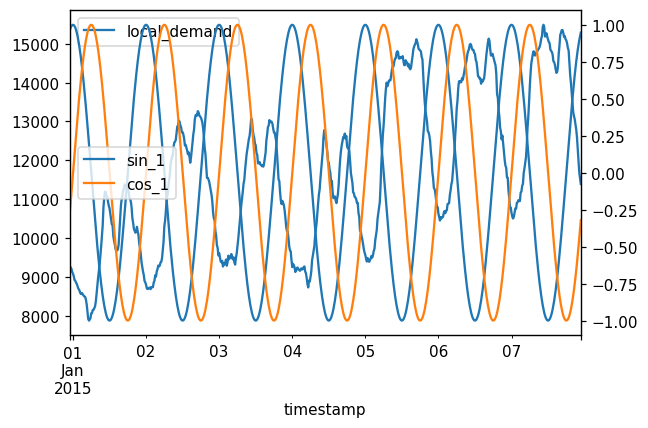

In [72]:
# Fourier analysis and decomposition

period = 24 * 60 * 60  # in seconds (from autocorrelation plot)
t_s = np.array(3600*df.index.hour + 60*df.index.minute + df.index.second)
for i in range(1, 4):
    df.loc[:, f"cos_{i}"] = np.sin((2*np.pi*i*t_s)/period)
    df.loc[:, f"sin_{i}"] = np.cos((2*np.pi*i*t_s)/period)
    
n_samples = 7*4*24

fig, ax = plt.subplots(1, 1, dpi=110)
ax = df.iloc[:n_samples].plot(y="local_demand", ax=ax)
ax2 = ax.twinx()
ax2=df.iloc[:n_samples].plot(y="sin_1", ax=ax2)
ax2=df.iloc[:n_samples].plot(y="cos_1", ax=ax2)

fig.tight_layout()